# Question 2

In [1]:
from pyspark import SparkConf, SparkContext
import re
import numpy as np
import matplotlib.pyplot as plt 
conf = SparkConf()
sc = SparkContext(conf=conf)

In [2]:
MAX_ITER = 20
k = 10

In [274]:
# Load data
def load(path):
    lines = sc.textFile(path)
    slines = lines.map(lambda line: [float(v) for v in re.split(r' ', line)])
    return slines

# Distance
def dist(l, c, dist_type):
    if dist_type == 'Euclidean':
        return np.linalg.norm(np.array(l)-c, 2)
    elif dist_type == 'Manhattan':
        return np.linalg.norm(np.array(l)-c, 1)
    else:
        raise ValueError("Invalid Distance Type!")

# Minimum and corresponding index
def min_and_ind(l):
    return (np.min(l), np.argmin(l))

# Calculate L2 centroids
def c_2(l):
    c = np.zeros(len(l[0]))
    for v in l:
        c += np.array(v)
    return c/len(l)
    

# Do k-means clustering
def clustering(data, c, dist_type = 'Euclidean'):
    
    it = 0
    costs = []
    c_array = np.array(c.collect())
    
    while it < MAX_ITER:
        # print(c_array[0][0:3])
        clusters = data.map(lambda line: (line, min_and_ind([dist(line, cc, dist_type) for cc in c_array])))\
                       .map(lambda line: (line[1][1], (line[0], line[1][0])))\
                       .groupByKey()\
                       .mapValues(lambda vs: [v for v in vs])
        cost = clusters.map(lambda line: (1, sum([v[1] for v in line[1]])))\
                       .reduceByKey(lambda n1, n2: n1+n2)\
                       .collect()[0][1]
        centroids = clusters.map(lambda line: [v[0] for v in line[1]])\
                            .map(lambda line: list(c_2(line)))\
                            .collect()

        it += 1
        costs.append(cost)
        c_array = np.array(centroids)
    
    return costs

# Plot the cost versus iteration
def solve(data, c1, c2, dist_type):
    
    costs1 = clustering(data, c1, dist_type)
    costs2 = clustering(data, c2, dist_type)
    
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(costs1, 'ro-')
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.subplot(122)
    plt.plot(costs2, 'bo-')
    plt.xlabel('iteration')
    plt.ylabel('cost')
    plt.show()
    print('The percent change after 10 iterations for c1 is '+str((1-costs1[9]/costs1[0])*100)+'%')
    print('The percent change after 10 iterations for c2 is '+str((1-costs2[9]/costs2[0])*100)+'%')

------Solution for 2------


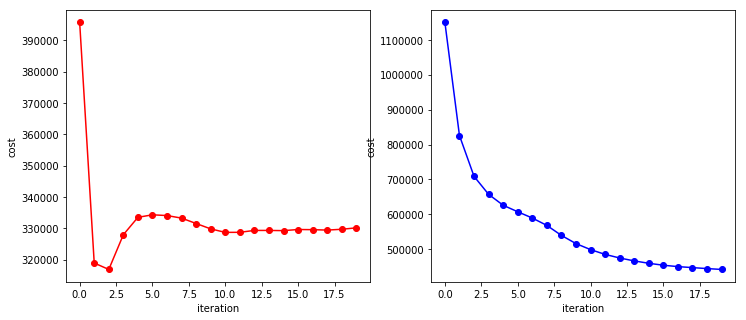

The percent change after 10 iterations for c1 is 16.65429963858419%
The percent change after 10 iterations for c2 is 55.15937469938963%
------Solution for 2------


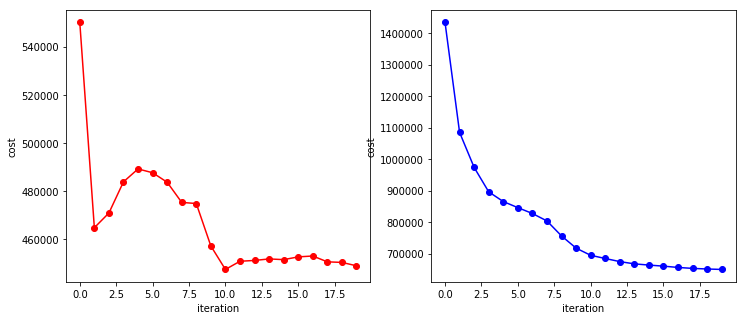

The percent change after 10 iterations for c1 is 16.882286547298165%
The percent change after 10 iterations for c2 is 49.96768955555581%


In [275]:
if __name__ == '__main__':
    data = load('data/data.txt')
    c1 = load('data/c1.txt')
    c2 = load('data/c2.txt')
    solve(data, c1, c2, 'Euclidean')
    solve(data, c1, c2, 'Manhattan')